# Researching OpenAI's GPTBot



Install the GreyNoise python package.

In [521]:
%pip install greynoise

Note: you may need to restart the kernel to use updated packages.


And then import the client object from the package library.

In [522]:
from greynoise import GreyNoise

We're also going to need `pandas` and `matplotlib`

In [523]:
import pandas as pd
import matplotlib.pyplot as plt


Let's get our API key from our env variable.

In [524]:
import os

GREYNOISE_KEY = os.environ.get('GREYNOISE_KEY')

Now let's make a GreyNoise client object.

In [525]:
gn = GreyNoise(GREYNOISE_KEY)

Our GNQL query for `GPTBot` is `tags:GPTBot`.

In [526]:
GNQL_QUERY = 'tags:GPTBot'

I'm going to make a quick function to run GNQL queries. I'm also going to make a query to turn the response into a `pandas` dataframe.

In [527]:
def make_gnql_request(query: str):
    return gn.session.get(
        f'{gn.api_server}/{gn.EP_GNQL}',
        headers={'key': f'{gn.api_key}'},
        params={'query': f'{query}'}
    )

def gnql_to_df(gnql_response):
    if gnql_response.status_code != 200:
        raise Exception(f'Bad status code: {gnql_response.status_code}')
    if gnql_response.json()['message'] != 'ok':
        raise Exception(f'Bad status: {gnql_response.json()["message"]}')
    
    return pd.json_normalize(gnql_response.json()['data'])

def get_gnql_df(query: str):
    return gnql_to_df(make_gnql_request(query))

Now make a dataframe from just a GNQL query.

In [528]:
df = get_gnql_df(GNQL_QUERY)
df.head()

,ip,bot,vpn,vpn_service,spoofable,first_seen,last_seen,seen,tags,actor,...,metadata.region,metadata.destination_countries,metadata.source_country,metadata.source_country_code,metadata.destination_country_codes,raw_data.scan,raw_data.web.paths,raw_data.ja3,raw_data.hassh,raw_data.web.useragents
0,20.15.240.77,False,False,N/A,False,2023-08-08,2023-08-08,True,"[GPTBot, TLS/SSL Crawler, Web Crawler]",unknown,...,Iowa,[United States],United States,US,[US],"[{'port': 443, 'protocol': 'TCP'}]",[/index.php],[],[],NaN
1,20.15.241.14,False,False,N/A,False,2023-08-08,2023-08-08,True,"[GPTBot, TLS/SSL Crawler, Web Crawler]",unknown,...,Iowa,"[United States, Georgia]",United States,US,"[US, GE]","[{'port': 443, 'protocol': 'TCP'}]","[/, /index.php]",[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[],NaN
2,20.15.242.139,False,False,N/A,False,2023-08-08,2023-08-08,True,"[GPTBot, TLS/SSL Crawler, Web Crawler]",unknown,...,Iowa,"[Georgia, United States]",United States,US,"[GE, US]","[{'port': 443, 'protocol': 'TCP'}]",NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[],NaN
3,20.15.240.96,False,False,N/A,False,2023-08-08,2023-08-08,True,"[GPTBot, TLS/SSL Crawler, Web Crawler]",unknown,...,Iowa,[United States],United States,US,[US],"[{'port': 443, 'protocol': 'TCP'}]",NaN,[],[],NaN
4,20.15.241.13,False,False,N/A,False,2023-08-08,2023-08-08,True,"[GPTBot, TLS/SSL Crawler, Web Crawler]",unknown,...,Iowa,[United States],United States,US,[US],"[{'port': 443, 'protocol': 'TCP'}]",[/index.php],[],[],NaN


## EDA on our GreyNoise GPTBot results

Let's run a couple of aggregations to just checkout the data.

### Columns in our dataframe

In [529]:
df.columns

Index(['ip', 'bot', 'vpn', 'vpn_service', 'spoofable', 'first_seen',
       'last_seen', 'seen', 'tags', 'actor', 'classification', 'cve',
       'metadata.asn', 'metadata.city', 'metadata.country',
       'metadata.country_code', 'metadata.organization', 'metadata.category',
       'metadata.tor', 'metadata.rdns', 'metadata.os', 'metadata.sensor_count',
       'metadata.sensor_hits', 'metadata.region',
       'metadata.destination_countries', 'metadata.source_country',
       'metadata.source_country_code', 'metadata.destination_country_codes',
       'raw_data.scan', 'raw_data.web.paths', 'raw_data.ja3', 'raw_data.hassh',
       'raw_data.web.useragents'],
      dtype='object')

### Top IPs with GPTBot tags by volume

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '20.15.240.67'),
  Text(1, 0, '20.15.240.107'),
  Text(2, 0, '20.15.240.187'),
  Text(3, 0, '20.15.240.83'),
  Text(4, 0, '40.83.2.78'),
  Text(5, 0, '20.15.240.75'),
  Text(6, 0, '20.15.240.89'),
  Text(7, 0, '20.15.240.92'),
  Text(8, 0, '20.15.242.132'),
  Text(9, 0, '40.83.2.71')])

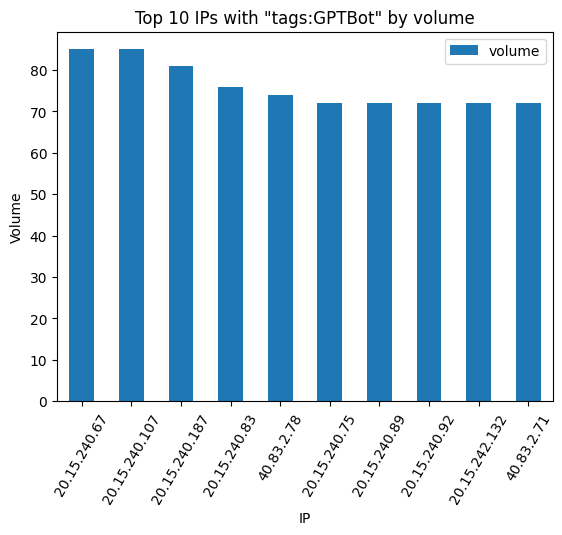

In [530]:
df[['ip','metadata.sensor_hits']]\
    .rename(columns={'metadata.sensor_hits':'volume'})\
    .groupby('ip')\
    .sum('volume')\
    .sort_values('volume',ascending=False)\
    .head(10)\
    .plot(kind='bar',
          title=f'Top 10 IPs with "{GNQL_QUERY}" by volume',
          xlabel='IP',
          ylabel='Volume'
    )
plt.xticks(rotation=60)

Looks like when you look at the total `metadata.sensor_hits`, we start to see IP addresses that weren't on the list we got from OpenAI. If I had to guess, these may have been previously used.

### Top ASNs with GPTBot tags by volume

(array([0]), [Text(0, 0, 'Microsoft Corporation')])

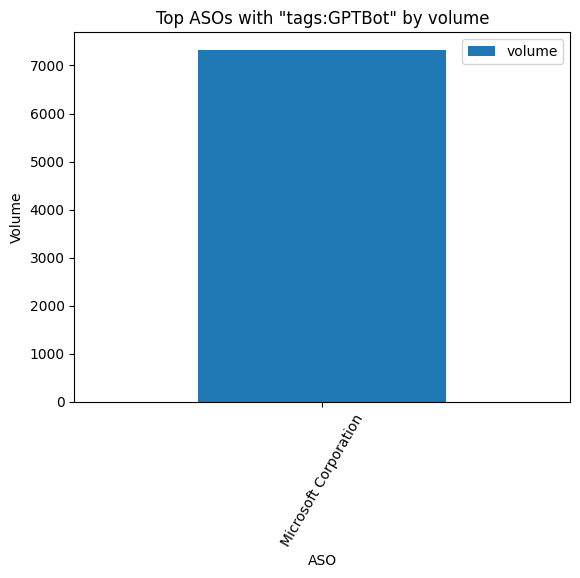

In [531]:
df[['metadata.organization','metadata.sensor_hits']]\
    .rename(columns={'metadata.organization':'aso','metadata.sensor_hits':'volume'})\
    .groupby('aso')\
    .sum('volume')\
    .sort_values('volume',ascending=False)\
    .head(10)\
    .plot(kind='bar',
          title=f'Top ASOs with "{GNQL_QUERY}" by volume',
          xlabel='ASO',
          ylabel='Volume'
    )
plt.xticks(rotation=60)

It's all Microsoft.

### Do we have any user agents to work with?

In [532]:
df[df['raw_data.web.useragents'].notna()][['raw_data.web.useragents','metadata.sensor_hits']]

,raw_data.web.useragents,metadata.sensor_hits
13,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",53
36,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",62
58,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",63
62,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",36
96,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",58
116,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",69
121,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",74
142,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",35


Let's get a better look.

In [533]:
df[df['raw_data.web.useragents'].notna()][['raw_data.web.useragents','metadata.sensor_hits']].to_dict('records')

[{'raw_data.web.useragents': ['Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)'],
  'metadata.sensor_hits': 53},
 {'raw_data.web.useragents': ['Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)'],
  'metadata.sensor_hits': 62},
 {'raw_data.web.useragents': ['Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)'],
  'metadata.sensor_hits': 63},
 {'raw_data.web.useragents': ['Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)'],
  'metadata.sensor_hits': 36},
 {'raw_data.web.useragents': ['Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)'],
  'metadata.sensor_hits': 58},
 {'raw_data.web.useragents': ['Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)'],
  'metadata.sensor_hits

They appear to be the same.

OK, so how much traffic did GreyNoise observe that self-identified as `GPTBot` via the User-Agent header? And how much traffic did GreyNoise observe that had no `GPTBot` header, but was tagged as `GPTBot`?

In [534]:
df[['raw_data.web.useragents','metadata.sensor_hits']]\
    .rename(columns={'raw_data.web.useragents':'has_useragent','metadata.sensor_hits':'volume'})

,has_useragent,volume
0,NaN,33
1,NaN,61
2,NaN,49
3,NaN,45
4,NaN,41
...,...,...
139,NaN,43
140,NaN,63
141,NaN,59
142,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",35


Let's just turn the `has_useragent` column into a boolean.

In [535]:
df_useragent_traffic = df[['raw_data.web.useragents','metadata.sensor_hits']]\
    .rename(columns={'raw_data.web.useragents':'has_useragent','metadata.sensor_hits':'volume'})
df_useragent_traffic

,has_useragent,volume
0,NaN,33
1,NaN,61
2,NaN,49
3,NaN,45
4,NaN,41
...,...,...
139,NaN,43
140,NaN,63
141,NaN,59
142,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",35


In [536]:
df_useragent_traffic['has_useragent'] = df[['raw_data.web.useragents','metadata.sensor_hits']]\
    .rename(columns={'raw_data.web.useragents':'has_useragent','metadata.sensor_hits':'volume'})[['has_useragent']].notna()['has_useragent']

Ugly. But we should have that dataframe now.

In [537]:
df_useragent_traffic

,has_useragent,volume
0,False,33
1,False,61
2,False,49
3,False,45
4,False,41
...,...,...
139,False,43
140,False,63
141,False,59
142,True,35


We can now group by that `has_useragent` column.

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

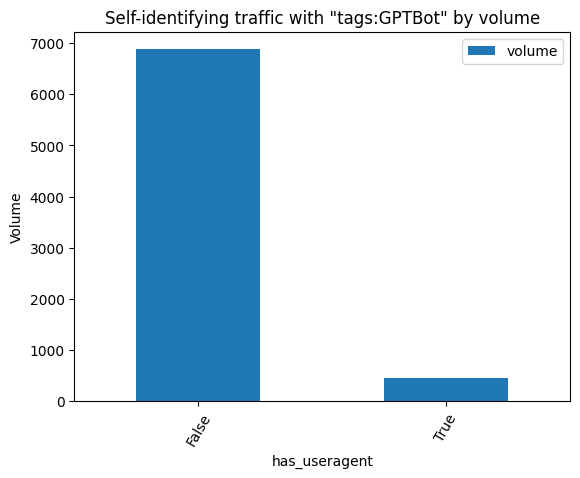

In [538]:
df_useragent_traffic\
    .groupby('has_useragent')\
    .sum('volume')\
    .sort_values('volume',ascending=False)\
    .plot(kind='bar',
          title=f'Self-identifying traffic with "{GNQL_QUERY}" by volume',
          xlabel='has_useragent',
          ylabel='Volume'
    )
plt.xticks(rotation=60)

### JA3 fingerprint of GPTBot traffic

Let's pull down the traffic with user agents and with JA3 prints.

In [539]:
df_ja3 = df[['raw_data.web.useragents','raw_data.ja3','metadata.sensor_hits']]
df_ja3

,raw_data.web.useragents,raw_data.ja3,metadata.sensor_hits
0,NaN,[],33
1,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,61
2,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,49
3,NaN,[],45
4,NaN,[],41
...,...,...,...
139,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,43
140,NaN,[],63
141,NaN,[],59
142,"[Mozilla/5.0 AppleWebKit/537.36 (KHTML, like G...",[],35


Let's clear out some of these lists and make it single value.

In [540]:
for index, row in df_ja3.iterrows():
     # change the type value for the user agents
    if type(df_ja3.loc[index]['raw_data.web.useragents']) == type([]):
        if len(df_ja3.loc[index]['raw_data.web.useragents']) > 0:
            df_ja3.at[index, 'raw_data.web.useragents'] = df_ja3.loc[index]['raw_data.web.useragents'][0]
    else:
        df_ja3.at[index, 'raw_data.web.useragents'] = None
    # change the type value for the ja3 prints
    if type(df_ja3.loc[index]['raw_data.ja3']) == type([]):
        if len(df_ja3.loc[index]['raw_data.ja3']) > 0:
            df_ja3.at[index, 'raw_data.ja3'] = df_ja3.loc[index]['raw_data.ja3'][0]
        else:
            df_ja3.at[index, 'raw_data.ja3'] = None

In [541]:
df_ja3.notnull().sum()

raw_data.web.useragents      8
raw_data.ja3                19
metadata.sensor_hits       144
dtype: int64

Turn it into records, I wanna see something...

In [542]:
df_ja3.to_dict('records')

[{'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 33},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': {'fingerprint': '8d9f7747675e24454cd9b7ed35c58707',
   'port': 443},
  'metadata.sensor_hits': 61},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': {'fingerprint': '8d9f7747675e24454cd9b7ed35c58707',
   'port': 443},
  'metadata.sensor_hits': 49},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 45},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 41},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 57},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 45},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 72},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'metadata.sensor_hits': 60},
 {'raw_data.web.useragents': None,
  'raw_data.ja3': None,
  'me

ugh really gotta dive just to get the fingerprint value huh

In [543]:
ja3_records = []
for row in df_ja3.to_dict('records'):
    ja3_value = row['raw_data.ja3']
    if ja3_value is not None:
        ja3_value = ja3_value['fingerprint']
    record = {
        'user_agent': row['raw_data.web.useragents'],
        'ja3': ja3_value,
        'volume': row['metadata.sensor_hits']
    }
    ja3_records.append(record)

In [544]:
ja3_records

[{'user_agent': None, 'ja3': None, 'volume': 33},
 {'user_agent': None, 'ja3': '8d9f7747675e24454cd9b7ed35c58707', 'volume': 61},
 {'user_agent': None, 'ja3': '8d9f7747675e24454cd9b7ed35c58707', 'volume': 49},
 {'user_agent': None, 'ja3': None, 'volume': 45},
 {'user_agent': None, 'ja3': None, 'volume': 41},
 {'user_agent': None, 'ja3': None, 'volume': 57},
 {'user_agent': None, 'ja3': None, 'volume': 45},
 {'user_agent': None, 'ja3': None, 'volume': 72},
 {'user_agent': None, 'ja3': None, 'volume': 60},
 {'user_agent': None, 'ja3': None, 'volume': 45},
 {'user_agent': None, 'ja3': None, 'volume': 60},
 {'user_agent': None, 'ja3': None, 'volume': 57},
 {'user_agent': None, 'ja3': None, 'volume': 54},
 {'user_agent': 'Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)',
  'ja3': '8d9f7747675e24454cd9b7ed35c58707',
  'volume': 53},
 {'user_agent': None, 'ja3': None, 'volume': 60},
 {'user_agent': None, 'ja3': None, 'volume': 56},
 {'use

In [545]:
df_ja3_records = pd.DataFrame(ja3_records)
df_ja3_records

,user_agent,ja3,volume
0,None,None,33
1,None,8d9f7747675e24454cd9b7ed35c58707,61
2,None,8d9f7747675e24454cd9b7ed35c58707,49
3,None,None,45
4,None,None,41
...,...,...,...
139,None,8d9f7747675e24454cd9b7ed35c58707,43
140,None,None,63
141,None,None,59
142,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",None,35


In [546]:
df_ja3_records[df_ja3_records['ja3'].notna()]

,user_agent,ja3,volume
1,None,8d9f7747675e24454cd9b7ed35c58707,61
2,None,8d9f7747675e24454cd9b7ed35c58707,49
13,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",8d9f7747675e24454cd9b7ed35c58707,53
24,None,8d9f7747675e24454cd9b7ed35c58707,61
34,None,8d9f7747675e24454cd9b7ed35c58707,46
36,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",8d9f7747675e24454cd9b7ed35c58707,62
58,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",8d9f7747675e24454cd9b7ed35c58707,63
62,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",8d9f7747675e24454cd9b7ed35c58707,36
70,None,8d9f7747675e24454cd9b7ed35c58707,46
71,None,8d9f7747675e24454cd9b7ed35c58707,85


Looks like we got that JA3 alllll over this GPTBot traffic.

Is it really just super common? It could literally just be a headless browser binary on Linux.
Let's do a GNQL query to find out.

In [547]:
GNQL_QUERY_2 = 'raw_data.ja3.fingerprint:8d9f7747675e24454cd9b7ed35c58707'
df_ja3_query = get_gnql_df(GNQL_QUERY_2)
df_ja3_query

,ip,bot,vpn,vpn_service,spoofable,first_seen,last_seen,seen,tags,actor,...,metadata.region,metadata.destination_countries,metadata.source_country,metadata.source_country_code,metadata.destination_country_codes,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,raw_data.hassh
0,85.239.240.253,False,False,N/A,False,2023-07-30,2023-08-24,True,"[ENV Crawler, PHPUnit RCE, Python Requests Cli...",unknown,...,Missouri,"[Australia, Ukraine, India, United Kingdom, Ru...",United States,US,"[AU, UA, IN, GB, RU, JP, DE, TW, ES, CN, TR, U...","[{'port': 80, 'protocol': 'TCP'}, {'port': 443...","[/.env, /vendor/phpunit/phpunit/src/Util/PHP/e...",[Mozilla/5.0 (Linux; U; Android 4.4.2; en-US; ...,[{'fingerprint': 'db687c576d7ee0017b289fc05e0f...,[]
1,114.99.121.160,False,False,N/A,False,2022-08-20,2023-08-24,True,[TLS/SSL Crawler],unknown,...,Anhui,"[Canada, United States, India]",China,CN,"[CA, US, IN]","[{'port': 443, 'protocol': 'TCP'}]",NaN,NaN,[{'fingerprint': '473cd7cb9faa642487833865d516...,[]
2,185.36.81.23,False,False,N/A,False,2018-10-24,2023-08-24,True,"[ENV Crawler, PHPUnit RCE, Python Requests Cli...",unknown,...,Vilnius,"[Germany, Canada, United States, Netherlands, ...",Lithuania,LT,"[DE, CA, US, NL, TR]","[{'port': 80, 'protocol': 'TCP'}, {'port': 443...","[/, /vendor/phpunit/phpunit/src/Util/PHP/eval-...",[Mozilla/5.0 (Linux; U; Android 4.4.2; en-US; ...,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]
3,162.250.191.179,False,False,N/A,False,2023-08-02,2023-08-24,True,[TLS/SSL Crawler],unknown,...,Quebec,"[Brazil, Romania, Netherlands, Turkey, Germany...",Canada,CA,"[BR, RO, NL, TR, DE, IE, FR, GB, IN, LV, KZ, C...","[{'port': 443, 'protocol': 'TCP'}]",NaN,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]
4,135.148.237.208,False,False,N/A,False,2023-07-27,2023-08-24,True,"[ENV Crawler, TLS/SSL Crawler, Web Crawler]",unknown,...,Virginia,"[South Korea, Japan, Australia, Brazil, Hong K...",United States,US,"[KR, JP, AU, BR, HK, DE, ZA, US, FR]","[{'port': 80, 'protocol': 'TCP'}, {'port': 443...","[/, /.env]",[Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,89.163.145.112,False,True,RUS_VPN,False,2023-05-15,2023-05-29,True,"[Open Proxy Scanner, Web Crawler, ZMap Client]",unknown,...,North Rhine-Westphalia,"[Russia, United Kingdom, Ukraine]",Germany,DE,"[RU, GB, UA]","[{'port': 88, 'protocol': 'TCP'}, {'port': 90,...","[/login.rsp, /image/lgbg.jpg, /skin/default_1/...",[Chrome (AppleWebKit/537.1; Chrome50.0; Window...,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]
146,5.113.60.138,False,False,N/A,False,2019-07-27,2023-05-29,True,[TLS/SSL Crawler],unknown,...,Tehran,"[United States, Netherlands, Germany, France]",Iran,IR,"[US, NL, DE, FR]","[{'port': 443, 'protocol': 'TCP'}]",NaN,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]
147,5.217.167.150,False,False,N/A,False,2023-05-29,2023-05-29,True,[TLS/SSL Crawler],unknown,...,Tehran,"[Finland, Germany, Ukraine, Kazakhstan, Romani...",Iran,IR,"[FI, DE, UA, KZ, RO, PL]","[{'port': 443, 'protocol': 'TCP'}]",NaN,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]
148,2.147.44.248,False,False,N/A,False,2021-03-12,2023-05-28,True,[TLS/SSL Crawler],unknown,...,Tehran,[United States],Iran,IR,[US],"[{'port': 443, 'protocol': 'TCP'}]",NaN,NaN,[{'fingerprint': '8d9f7747675e24454cd9b7ed35c5...,[]


Seems like a mixed crowd...

Let's grab the os info and the hits.

In [548]:
df_ja3_query[['metadata.os','metadata.sensor_hits']]

,metadata.os,metadata.sensor_hits
0,Windows 7/8,610
1,Windows 2000,88
2,unknown,84
3,Linux 2.2-3.x,3371
4,unknown,168
...,...,...
145,Windows 2000,3036
146,unknown,26
147,Windows 2000,65
148,unknown,6


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Windows 2000'),
  Text(1, 0, 'Windows 7/8'),
  Text(2, 0, 'Linux 2.2-3.x'),
  Text(3, 0, 'Linux 2.2.x-3.x (Embedded)'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'Linux 3.11+')])

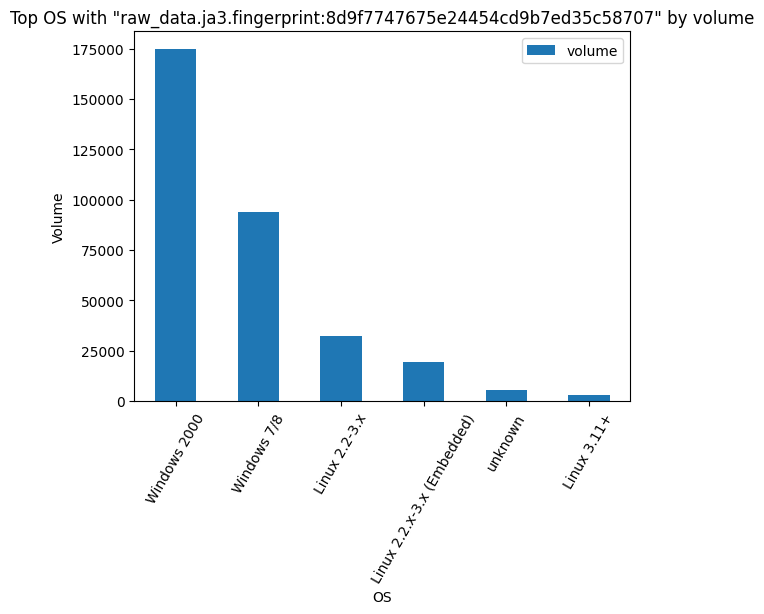

In [549]:
df_ja3_query[['metadata.os','metadata.sensor_hits']]\
    .rename(columns={'metadata.os':'os','metadata.sensor_hits':'volume'})\
    .groupby('os')\
    .sum('volume')\
    .sort_values('volume',ascending=False)\
    .head(10)\
    .plot(kind='bar',
          title=f'Top OS with "{GNQL_QUERY_2}" by volume',
          xlabel='OS',
          ylabel='Volume'
    )
plt.xticks(rotation=60)

OK, we should do the same on GPTBot traffic.

### OS distribution of GPTBot traffic

(array([0, 1]), [Text(0, 0, 'unknown'), Text(1, 0, 'Linux 2.2-3.x')])

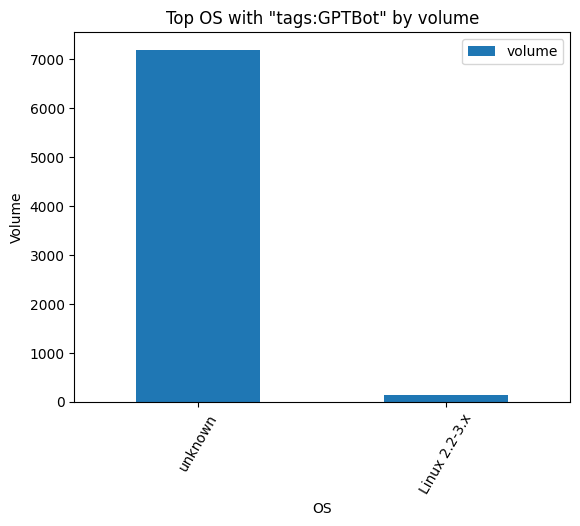

In [550]:
df[['metadata.os','metadata.sensor_hits']]\
    .rename(columns={'metadata.os':'os','metadata.sensor_hits':'volume'})\
    .groupby('os')\
    .sum('volume')\
    .sort_values('volume',ascending=False)\
    .head(10)\
    .plot(kind='bar',
          title=f'Top OS with "{GNQL_QUERY}" by volume',
          xlabel='OS',
          ylabel='Volume'
    )
plt.xticks(rotation=60)

How many of these have a JA3 observed by GreyNoise?

In [551]:
df_tagged_traffic_records = df[['metadata.os','metadata.sensor_hits','raw_data.ja3']]\
    .rename(columns={'metadata.os':'os','raw_data.ja3':'ja3','metadata.sensor_hits':'volume'})\
    .to_dict('records')
df_tagged_traffic_records

[{'os': 'unknown', 'volume': 33, 'ja3': []},
 {'os': 'unknown',
  'volume': 61,
  'ja3': [{'fingerprint': '8d9f7747675e24454cd9b7ed35c58707', 'port': 443}]},
 {'os': 'unknown',
  'volume': 49,
  'ja3': [{'fingerprint': '8d9f7747675e24454cd9b7ed35c58707', 'port': 443}]},
 {'os': 'unknown', 'volume': 45, 'ja3': []},
 {'os': 'unknown', 'volume': 41, 'ja3': []},
 {'os': 'unknown', 'volume': 57, 'ja3': []},
 {'os': 'unknown', 'volume': 45, 'ja3': []},
 {'os': 'unknown', 'volume': 72, 'ja3': []},
 {'os': 'unknown', 'volume': 60, 'ja3': []},
 {'os': 'unknown', 'volume': 45, 'ja3': []},
 {'os': 'unknown', 'volume': 60, 'ja3': []},
 {'os': 'unknown', 'volume': 57, 'ja3': []},
 {'os': 'unknown', 'volume': 54, 'ja3': []},
 {'os': 'unknown',
  'volume': 53,
  'ja3': [{'fingerprint': '8d9f7747675e24454cd9b7ed35c58707', 'port': 443}]},
 {'os': 'unknown', 'volume': 60, 'ja3': []},
 {'os': 'unknown', 'volume': 56, 'ja3': []},
 {'os': 'unknown', 'volume': 45, 'ja3': []},
 {'os': 'unknown', 'volume': 30

In [552]:
for record in df_tagged_traffic_records:
    if type(record['ja3']) == type([]):
        if len(record['ja3']) > 0:
            record['ja3'] = True
        else:
            record['ja3'] = False
    else:
        record['ja3'] = False

In [553]:
df_tagged_traffic = pd.DataFrame(df_tagged_traffic_records)
df_tagged_traffic

,os,volume,ja3
0,unknown,33,False
1,unknown,61,True
2,unknown,49,True
3,unknown,45,False
4,unknown,41,False
...,...,...,...
139,unknown,43,True
140,unknown,63,False
141,unknown,59,False
142,unknown,35,False


(array([0, 1]), [Text(0, 0, 'unknown'), Text(1, 0, 'Linux 2.2-3.x')])

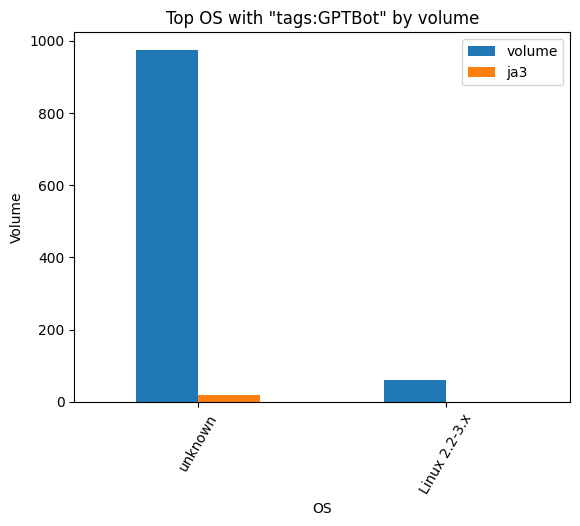

In [554]:
df_tagged_traffic[df_tagged_traffic['ja3'] == True]\
    .groupby('os')\
    .sum('volume')\
    .sort_values('volume',ascending=False)\
    .head(10)\
    .plot(kind='bar',
          title=f'Top OS with "{GNQL_QUERY}" by volume',
          xlabel='OS',
          ylabel='Volume'
    )
plt.xticks(rotation=60)

### Getting full list of IPs and first_seen/last_seen

Let's try and pin some of these hosts to specific time windwos-- maybe there is a pattern for some of this traffic that either doesn't self-identify as `GPTBot`, observed operating system, doesn't have a JA3 print, or is not in the publicly disclosed IP ranges from OpenAI.

For ease, let's just create some columns with booleans for each of the features listed above:
```
raw_data.web.useragents
metadata.os
raw_data.ja3
```

Kinda like pseudo-feature extraction, we will just make a column that states whether or not that row has that feature:
```
has_useragent
os_not_known
has_ja3
is_disclosed_ip
```

Make a column for `has_useragent`

In [555]:
df['has_useragent'] = df['raw_data.web.useragents'].notna()

make a column for `has_ja3`

In [556]:
has_ja3 = []
for record in df.to_dict('records'):
    if type(record['raw_data.ja3']) == type([]):
        if len(record['raw_data.ja3']) > 0:
            has_ja3.append(True)
        else:
            has_ja3.append(False)
    else:
        has_ja3.append(False)
df['has_ja3'] = pd.Series(has_ja3)

Make a column for `os_not_known`

In [557]:
os_not_known = []
for record in df.to_dict('records'):
    if record['metadata.os'] :
        if record['metadata.os'] == 'unknown':
            os_not_known.append(True)
        else:
            os_not_known.append(False)
    else:
        os_not_known.append(False)
df['os_not_known'] = pd.Series(os_not_known)

Make a column for `is_disclosed_ip`, based on OpenAI's list of disclosed GPTBot IP ranges: https://openai.com/gptbot-ranges.txt

In [558]:
import ipaddress

OPENAI_RANGES = [
    '20.15.240.64/28',
    '20.15.240.80/28',
    '20.15.240.96/28',
    '20.15.240.176/28',
    '20.15.241.0/28',
    '20.15.242.128/28',
    '20.15.242.144/28',
    '20.15.242.192/28',
    '40.83.2.64/28'
]

def check_openai_ip(ip):
    for openai_range in OPENAI_RANGES:
        if ipaddress.ip_address(ip) in ipaddress.ip_network(openai_range):
            return True
    return False

In [559]:
is_openai_ip = []
for record in df.to_dict('records'):
    is_openai_ip.append(check_openai_ip(record['ip']))
df['is_openai_ip'] = pd.Series(is_openai_ip)

Now we can cleanly look at those features over time.

In [560]:
df_features = df[[
    'first_seen',
    'last_seen',
    'has_useragent',
    'has_ja3',
    'os_not_known',
    'is_openai_ip',
    'metadata.sensor_hits'
]]
df_features.rename(columns={'metadata.sensor_hits':'volume'},inplace=True)
df_features

/var/folders/2q/v9nlyk3j2fx7wv892l6n0pvw0000gn/T/ipykernel_80788/463893595.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.rename(columns={'metadata.sensor_hits':'volume'},inplace=True)


,first_seen,last_seen,has_useragent,has_ja3,os_not_known,is_openai_ip,volume
0,2023-08-08,2023-08-08,False,False,True,True,33
1,2023-08-08,2023-08-08,False,True,True,True,61
2,2023-08-08,2023-08-08,False,True,True,True,49
3,2023-08-08,2023-08-08,False,False,True,True,45
4,2023-08-08,2023-08-08,False,False,True,True,41
...,...,...,...,...,...,...,...
139,2023-08-08,2023-08-08,False,True,True,True,43
140,2023-08-08,2023-08-08,False,False,True,True,63
141,2023-08-08,2023-08-08,False,False,True,True,59
142,2023-08-05,2023-08-08,True,False,True,True,35


wait are all these timestamps the same lol

In [561]:
set([x[0] for x in df_features[['first_seen']].values])

{'2020-05-08', '2022-03-02', '2023-08-04', '2023-08-05', '2023-08-08'}

In [562]:
set([x[0] for x in df_features[['last_seen']].values])

{'2023-08-08'}

Ok... I would blame this on maybe sporadic coverage on detecting GPTBot traffic. This of course may be partially because GPTBot may not have always self-identified or operated off Microsoft's cloud.

OK, let's make a reusable function to group by date and whether the selected feature is present or not.

In [563]:
def make_feature_histogram(df, time_column, feature_column):

    df_feature = df[[time_column,feature_column,'volume']]\
        .rename(columns={time_column:'time',feature_column:'feature'})\
        .groupby(['time','feature'])\
        .sum('volume')\
        .sort_values('time',ascending=True)\
        .reset_index()
    
    df_feature['time'] = pd.to_datetime(df_feature['time'])
    
    df_feature_pivot = df_feature.pivot(index='time',columns='feature',values='volume')
    
    df_feature_pivot.plot(kind='bar',
          title=f'feature:"{feature_column}" over "{time_column}" for {GNQL_QUERY}',
          xlabel=time_column,
          ylabel='volume',
          color=['red','blue']
    )
    return plt.xticks(rotation=75)



### GPTBot-tagged traffic over time without a self-identifying user agent

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2020-05-08 00:00:00'),
  Text(1, 0, '2022-03-02 00:00:00'),
  Text(2, 0, '2023-08-04 00:00:00'),
  Text(3, 0, '2023-08-05 00:00:00'),
  Text(4, 0, '2023-08-08 00:00:00')])

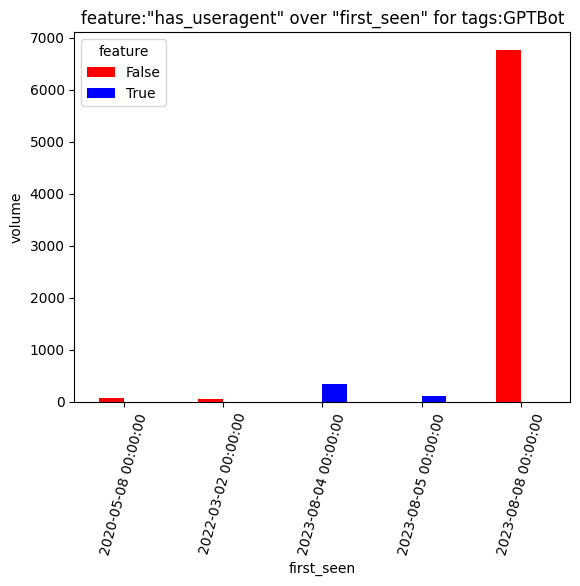

In [564]:
make_feature_histogram(df_features,'first_seen','has_useragent')

Some thoughts when looking at user agent precense in the GreyNoise-tagged GPTBot traffic:
- Much of the traffic is from the past 30 days.
- Large gaps in between captured traffic time periods.
- Most traffic did not self-identify as GPTBot in the user agent.
- 2023-08-04 and 2023-08-05: back-to-back days of consistent self-identifying GPTBot traffic.

### GPTBot-tagged traffic over time without a JA3 print

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2020-05-08 00:00:00'),
  Text(1, 0, '2022-03-02 00:00:00'),
  Text(2, 0, '2023-08-04 00:00:00'),
  Text(3, 0, '2023-08-05 00:00:00'),
  Text(4, 0, '2023-08-08 00:00:00')])

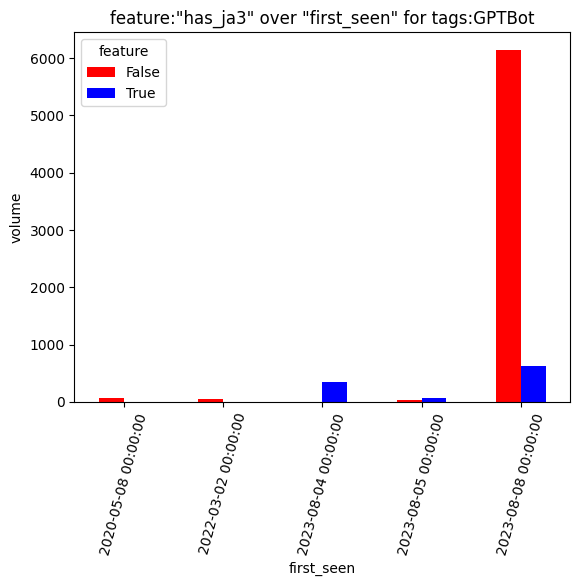

In [565]:
make_feature_histogram(df_features,'first_seen','has_ja3')

Some thoughts when looking at JA3 precense in the GreyNoise-tagged GPTBot traffic:
- Much of the traffic is from the past 30 days.
- Large gaps in between captured traffic time periods.
- 2023-08-04 and 2023-08-05: back-to-back days of consistent GPTBot traffic with JA3 observed.
- 2023-08-08 has JA3 traffic with somewhat consistent levels as 2023-08-04. and 2023-08-05.

### GPTBot-tagged traffic over time without known OS

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2020-05-08 00:00:00'),
  Text(1, 0, '2022-03-02 00:00:00'),
  Text(2, 0, '2023-08-04 00:00:00'),
  Text(3, 0, '2023-08-05 00:00:00'),
  Text(4, 0, '2023-08-08 00:00:00')])

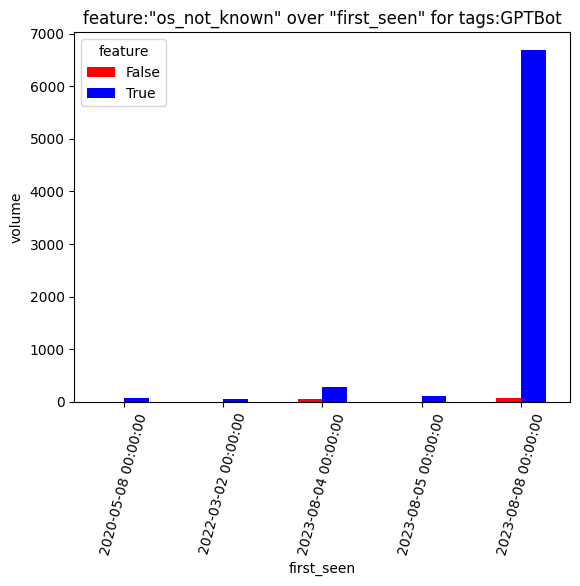

In [566]:
make_feature_histogram(df_features,'first_seen','os_not_known')

Some thoughts when looking at JA3 precense in the GreyNoise-tagged GPTBot traffic:
- Much of the traffic is from the past 30 days.
- Large gaps in between captured traffic time periods.
- 2023-05-08, 2022-03-02, 2023-08-04, 2023-08-05 all have consistent levels of traffic where the observed operating system was not known.
- large spike of traffic on 2023-08-08.
- large proportion of traffic observed on 2023-08-08 did not have an identified operating system.

### GPTBot-tagged traffic over time outside of disclosed OpenAI IP space

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2020-05-08 00:00:00'),
  Text(1, 0, '2022-03-02 00:00:00'),
  Text(2, 0, '2023-08-04 00:00:00'),
  Text(3, 0, '2023-08-05 00:00:00'),
  Text(4, 0, '2023-08-08 00:00:00')])

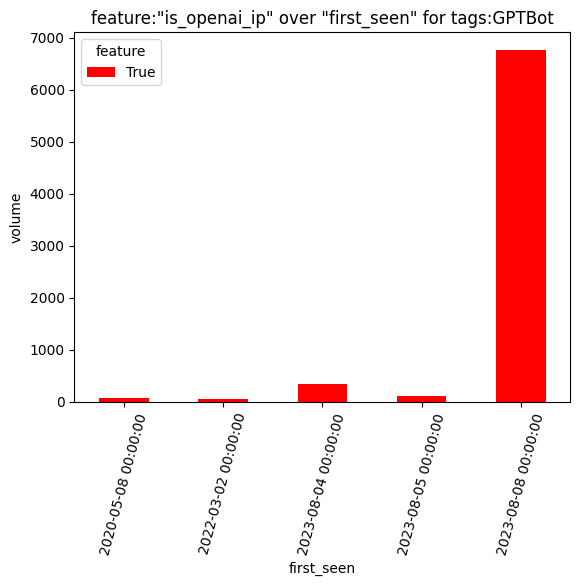

In [567]:
make_feature_histogram(df_features,'first_seen','is_openai_ip')

Some thoughts when looking at JA3 precense in the GreyNoise-tagged GPTBot traffic:
- Much of the traffic is from the past 30 days.
- Large gaps in between captured traffic time periods.
- All traffic observed is from the IP space disclosed by OpenAI.

## Conclusions and Caveats

- GreyNoise data does not have continuous oberservations of traffic-tagged as GPTBot.
- GreyNoise sensor likely do not typically attract GPTBot; it will depend on what application/software/protocol that the GreyNoise sensor is configured to mimic.
- Relying on GPTBot to self-identify via its user agent will result in mixed degrees of precision as a detection method.
- Despite consistent JA3 prints when a JA3 was able to be captured, most of the observed GPTBot-tagged traffic was not accompanied by a JA3 fingerprint.
- Traffic tagged as GPTBot by GreyNoise typically did not have an observed operating system.
- All traffic tagged by GreyNoise as GPTBot originated from the IP space that OpenAI has publicly disclosed.

When present, the top user agent in the traffic tagged by GreyNoise as GPTBot was:
```
Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; GPTBot/1.0; +https://openai.com/gptbot)
```

When present, the top JA3 fingerprint in the traffic tagged by GreyNoise as GPTBot was:
```
8d9f7747675e24454cd9b7ed35c58707
```

When present, the top operating in the traffic tagged by GreyNoise as GPTBot was:
```
Linux 2.2-3.x
```

The ASN and ASO for all the traffic tagged by GreyNoise as GPTBot was:
```
AS8075 Microsoft Corporation
```